<h1> Deep Learning for Image Captioning</h1>
<h4> In this project, we aim to generate descriptive captions for images using deep learning techniques. The core of our solution lies in a hybrid architecture that combines convolutional neural networks (CNNs) for image feature extraction and recurrent neural networks (RNNs) for natural language processing.</h4>

<h2>Image Feature Extraction</h2>
<h5>We start by extracting high-level features from images using a pre-trained ResNet50 model. ResNet50 is a state-of-the-art CNN architecture known for its excellent performance in image classification tasks. We extract features from each image and use them as input to our captioning model.</h5>

In [2]:
# import dependencies
import numpy as np
import pandas as pd
import cv2
from glob import glob
from keras.applications.resnet import ResNet50
from keras.models import Model
from sklearn import linear_model

#import local images
images_path = './Flickr_Data/Images/' 
images = glob(images_path+'*.jpg')
len(images)

#import resnet50

resnet = ResNet50(include_top=True)
# exclude the last layer because image features exits in the second to last
resnet_model = Model(inputs = resnet.input,outputs = resnet.layers[-2].output)
resnet_model.summary()

resnet_model.save('./models/resnet.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

/Users/yannietchi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
#now lets encode 5000 images using resnet50
images_features = {}
count = 0
for i in images:
    #read image using cv2
    img = cv2.imread(i)
    #Change image color to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # preprocess Image to shape used by model
    img = cv2.resize(img, (224,224)).reshape(1,224,224,3)
    
    #model prediction
    pred = resnet_model.predict(img,verbose=0).reshape(2048,)


    #grab only name of image without path   
    img_name = i.split('/')[-1]

    
    #save pred array to dictionary
    images_features[img_name] = pred
    
    count += 1
    
    if count > 3000:
        break
        

<h2>Text preprocess</h2>
<h5>We preprocess the captions associated with the images using a custom function called preprocess_captions. This function tokenizes each caption, converts it into lowercase, adds start and end tokens, and builds a vocabulary to map words to integers.</h5>


In [4]:
def preprocess_captions(captions, images_features):
    """
    Preprocesses captions and converts them into a dictionary format.

    Args:
    - captions (list): List of captions, where each caption is a string containing the image name and caption separated by a tab.
    - images_features (list): List of image names with features predicted by ResNet50.

    Returns:
    - captions_dict (dict): Dictionary where keys are image names and values are lists of preprocessed captions.
    """

    # Initialize an empty dictionary to store preprocessed captions
    captions_dict = {}

    # Iterate through each caption
    for caption in captions:
        try:
            # Split the caption at '\t' to extract image name and caption text
            img_name = caption.split('\t')[0][:-2] 
            caption_text = caption.split('\t')[1]
            
            # Check if the image name is in the list of images with features
            if img_name in images_features:
                # Add the caption to the dictionary under the corresponding image name
                if img_name not in captions_dict:
                    captions_dict[img_name] = [caption_text]
                else:
                    captions_dict[img_name].append(caption_text)
        except:
            pass # Handle exceptions gracefully, if any
    
    # Define a function to preprocess individual captions
    def process(txt):
        return "startofseq " + txt.lower() + " endofseq"
    
    # Preprocess each caption in the dictionary
    for image, captions in captions_dict.items():
        for idx, caption in enumerate(captions):
            captions_dict[image][idx] = process(caption)
    
    # Create a vocabulary for words in captions
    word_counts = {}
    word_index = 1
    for image, captions in captions_dict.items():
        for caption in captions:
            for word in caption.split():
                if word not in word_counts:
                    word_counts[word] = word_index
                    word_index += 1
    
    # Convert words in captions to integers based on the vocabulary
    for image, captions in captions_dict.items():
        for caption in captions:
            encoded_caption = [word_counts[word] for word in caption.split()]
            captions_dict[image][captions.index(caption)] = encoded_caption
    
    return word_counts,captions_dict

#Import captions
captions = open('./Flickr_Data/Flickr_TextData/Flickr8k.token.txt', 'rb').read().decode('utf-8').split('\n')

#create caption dictionary and track all words
word_counts, captions_dict = preprocess_captions(captions, images_features)


#record longest caption
MAX_LEN = 0
for image, captions in captions_dict.items():
    for caption in captions:
        if len(caption) > MAX_LEN:
            MAX_LEN = len(caption) 

<h2>Data Preparation</h2>

<h5>Before training the model, we need to prepare the data. This involves creating a generator function that generates batches of training data for the model. The function takes as input the image features, preprocessed captions, maximum sequence length, and vocabulary size.</h5>

In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 

#prep data for training
def generator(photo_features, captions_dict, max_len, vocab_size):
    """
    Generates batches of training data for a sequence-to-sequence model.

    Args:
    - photo_features (dict): A dictionary where keys are image identifiers and values are features extracted from the images.
    - captions_dict (dict): A dictionary where keys are image identifiers and values are lists of captions associated with the images.
    - max_len (int): The maximum length of the input sequence.
    - vocab_size (int): The size of the vocabulary.

    Returns:
    - X (list): A list of image features.
    - y_in (list): A list of input sequences (padded).
    - y_out (list): A list of output sequences (one-hot encoded).
    """
    X = []
    y_in = []
    y_out = []

    for image_id, captions_list in captions_dict.items():
        # Iterate over each caption for the current image
        for caption in captions_list:
            # Generate input-output pairs for each caption
            for i in range(1, len(caption)):
                # Prepare image features
                X.append(photo_features[image_id])

                # Prepare input sequence (prefix)
                input_seq = [caption[:i]]
                input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')[0]
                y_in.append(input_seq)

                # Prepare output sequence (next word)
                output_seq = caption[i]
                output_seq = to_categorical([output_seq], num_classes=vocab_size + 1)[0]
                y_out.append(output_seq)

    return X, y_in, y_out



X, y_in, y_out = generator(images_features, captions_dict, MAX_LEN, len(word_counts))

# convert to np array
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

<h4>Sequence Padding:</h4>
<h5>In this example, input_seq represents a list of sequences with varying lengths. We want to pad these sequences to ensure they all have a uniform length of max_len. The pad_sequences function pads each sequence with zeros at the end (padding='post') and truncates sequences longer than max_len from the end (truncating='post'). The result is stored in padded_seq, which now contains uniformly-length sequences suitable for input to a neural network</h5>
<h4>to_categorical:</h4>
<h5>output_seq represents the target word in each sequence, encoded as integers. We want to convert these integer representations to one-hot encoded vectors. The to_categorical function performs this conversion, where num_classes specifies the number of classes (in this case, the vocabulary size plus one for the padding token). The resulting one_hot_encoded_seq contains one-hot encoded vectors for each target word. By performing sequence padding and one-hot encoding, we preprocess the input and output data to make it suitable for training neural network models in natural language processing tasks such as text generation or classification.</h5>

<h2>Model Architecture</h2>
<h5>Our model architecture consists of two main components: an image processing branch and a text processing branch. These branches are integrated using a concatenation layer, allowing the model to jointly learn from both image features and caption sequences.</h5>

In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import plot_model

In [7]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(word_counts) +1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)


model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 36, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 128)           719744    
                                                                 
 lstm (LSTM)                 (None, 36, 256)           394240   

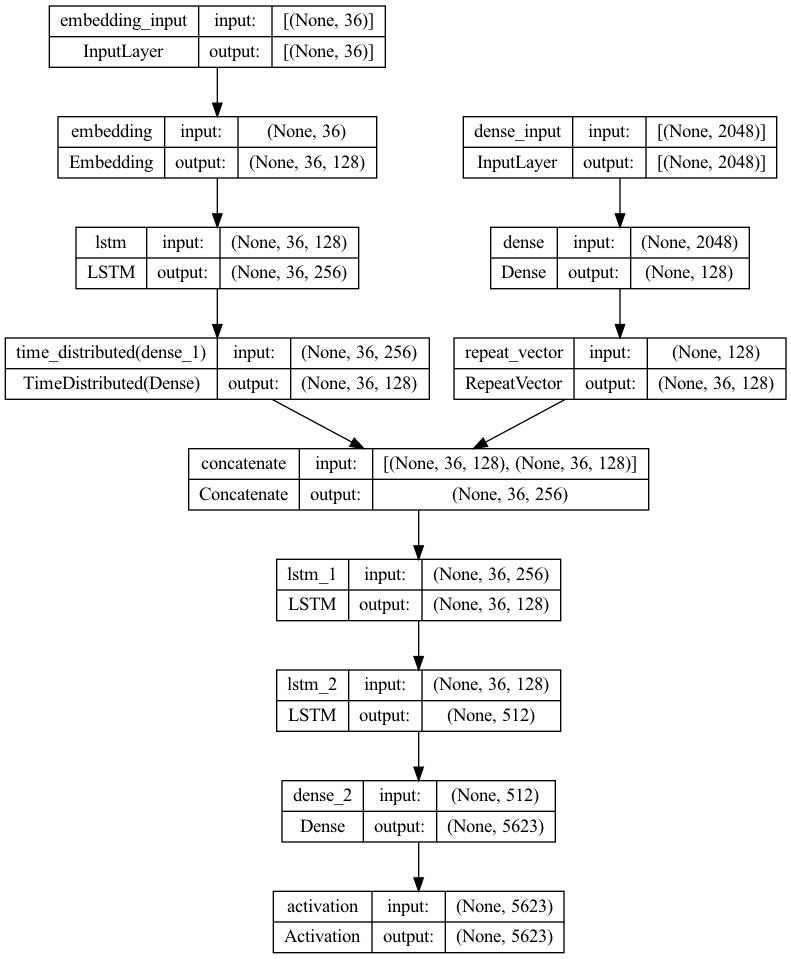

In [8]:
import tensorflow as tf

tf.keras.utils.plot_model(model, to_file='./models/model.png', show_shapes=True, show_layer_names=True)

#display model
from IPython.display import Image
Image(filename='./models/model.png')

In [9]:
#train model
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

model.save('./models/model.keras')

Epoch 1/50
377/377 [==============================] - 341s 896ms/step - loss: 5.0501 - accuracy: 0.1647
Epoch 2/50
377/377 [==============================] - 1259s 3s/step - loss: 4.3987 - accuracy: 0.2529
Epoch 3/50
377/377 [==============================] - 680s 2s/step - loss: 4.1418 - accuracy: 0.2777
Epoch 4/50
377/377 [==============================] - 332s 880ms/step - loss: 3.7858 - accuracy: 0.3177
Epoch 5/50
377/377 [==============================] - 1260s 3s/step - loss: 3.5445 - accuracy: 0.3444
Epoch 6/50
377/377 [==============================] - 2191s 6s/step - loss: 3.3875 - accuracy: 0.3629
Epoch 7/50
377/377 [==============================] - 1225s 3s/step - loss: 3.2637 - accuracy: 0.3781
Epoch 8/50
377/377 [==============================] - 311s 824ms/step - loss: 3.1567 - accuracy: 0.3905
Epoch 9/50
377/377 [==============================] - 316s 839ms/step - loss: 3.0655 - accuracy: 0.4024
Epoch 10/50
377/377 [==============================] - 321s 852ms/step - lo

In [66]:
#savemodel
#model.save('model.keras')


In [17]:
import pickle

#inverse dictionary
inv_dict = {v:k for k, v in word_counts.items()}


#save inverse dictionary and dictionary for model API
with open('./dictionary/inv_dict.pkl', 'wb') as f:
   pickle.dump(inv_dict, f)


with open('./dictionary/word_dict.pkl', 'wb') as f:
    pickle.dump(word_counts, f)